# Import Libraries

In [1]:
# Run in python console
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim (Topic Modeling Pacakge)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

# spacy for lemmatization
import spacy
from spacy.lang.en.examples import sentences 
spacy.cli.download("en_core_web_sm")

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
nltk.download('words')
words = set(nltk.corpus.words.words())

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /Users/sonia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/sonia/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
stop_new = ['mrt', 'station', 'see', 'bus', 'buses', 'line', 'account', 'one', 'full',
                     'get', 'min', 'class', 'year', 'pm', '', 'take', 'taxi', 'allow', 'last', 'almost',
                     'post', 'start', 'cross', 'car_rental', 'comfortdelgro', 'singapore', 'grab',
                     'night', 'find', 'need', 'build', 'photo', 'video', 'leave', 'car', 'train', 
                     'think', 'food', 'make', 'set', 'fresh', 'sbs', 'driver', 'delgro', 'comfort',  
                     'move',  'ever', 'blue', 'uber', 'go', 'look', 'use', 'also', 'give', 
                     'many', 'come', 'lot', 'seem', 'guess', 'definitely', 'sure', 'keep', 'much', 'already', 
                     'do', 'lol', 'people', 'well', 'back', 'week', 'u', 'want', 'day', 'will', 'know', 
                     'even', 'really', 'said', 'say', 'cab', 'public transport', 'taxis', 'public', 
                     'transport', 'thing', 'still', 'got', 'now', 's', 'stop', 'around', 'another', 
                     'smrt', 'next', 'us', 'may', 'person', 'years', 'going', 'trains', 'way', 
                     'seat', 'guy', 'https', 'always', 'riders', 'cabbie', 'sg', 'drivers', 'auntie', 'man', 
                     'uncle', 'stops', 'someone', 'something', 'andy', 'cabs', 'cabbies', 'order', 'delivery', 
                     'gojek', 'quite','fucking', 'every', 'getting', 'trying', 'told', 'something', 'singaporean', 
                     'feel', 'lta', 'fuck', 'without', 'let', 'made', 'getting', 'passenger', 'restaurant', 'grabfood', 
                     'merchant', 'don', 't', 'customer', 'cars', 'actually', 'senior', 'entrepreneur', 'rental', 'cars', 'current']

stop_words.extend(stop_new)

# Import DataFrame

In [2]:
df = pd.read_csv('2015_2019_filtered_planning_area_csv.csv', encoding='utf-8')

In [3]:
df.head()

,uid,year,sub_sector_verbatim,weight_of_market_share,customer_expectations_score,perceived_overall_quality_score,perceived_value_score,customer_satisfaction_score,customer_loyalty‎_user_trust_score,trains_sufficient_train_arrival_info,...,bookingapp_accuracy_of_time_estimate,bookingapp_app_promotions,bookingapp_ease_of_getting_ride,app_with_fares_charged,education,gender,housetype,postal_code,verbatim_reasons,planning_area
0,93,2019,MRT/LRT,0.038336,66.144710,81.386766,83.840623,70.822366,70.135632,9,...,,,,,7,2,4,670177,"THEY MAINTAINED THE TRAINS AND STATIONS WELL, ...",BUKIT PANJANG
1,154,2019,MRT/LRT,0.187418,70.727360,62.339718,61.618400,58.830962,67.118773,8,...,,,,,5,2,3,542325,SELF HELP TOP MACHINE IS VERY USER FRIENDLY,SENGKANG
2,157,2019,Public Buses,1.000239,62.605974,70.058748,82.826044,59.711255,83.559386,,...,,,,,7,1,3,542325,THE BUSES ARE CLEAN AND WELL MAINTAINED,SENGKANG
3,186,2019,Public Buses,1.594724,58.819786,78.495738,83.840623,67.142361,74.098572,,...,,,,,7,2,3,542267,NaN,SENGKANG
4,222,2019,MRT/LRT,0.187418,70.452854,59.665597,72.729511,59.235561,62.388366,7,...,,,,,7,1,4,543121,"WAITING TIME IS SHORT, ACCURATE ARRIVAL TIMING...",SENGKANG


# Prepare DataFrame for Topic Modelling

# Tokenize Each Sentence

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this.
Additionally I have set deacc=True to remove the punctuations.

Create Function

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

Execute Function

In [33]:
df_data_words = list(sent_to_words(df['verbatim_reasons']))


In [34]:
df_data_words

[['they',
  'maintained',
  'the',
  'trains',
  'and',
  'stations',
  'well',
  'always',
  'clean',
  'and',
  'well',
  'kept'],
 ['self', 'help', 'top', 'machine', 'is', 'very', 'user', 'friendly'],
 ['the', 'buses', 'are', 'clean', 'and', 'well', 'maintained'],
 ['nan'],
 ['waiting',
  'time',
  'is',
  'short',
  'accurate',
  'arrival',
  'timing',
  'provided'],
 ['able',
  'to',
  'choose',
  'to',
  'use',
  'the',
  'fixed',
  'rate',
  'option',
  'so',
  'no',
  'need',
  'to',
  'pay',
  'for',
  'booking',
  'fee'],
 ['able',
  'to',
  'track',
  'the',
  'live',
  'location',
  'of',
  'my',
  'taxi',
  'so',
  'will',
  'know',
  'that',
  'it',
  'is',
  'reaching',
  'me',
  'soon'],
 ['enjoyed',
  'good',
  'conversation',
  'with',
  'the',
  'driver',
  'throughout',
  'the',
  'whole',
  'journey',
  'without',
  'getting',
  'bored'],
 ['trains',
  'aircon',
  'are',
  'cooling',
  'and',
  'comfortable',
  'to',
  'ride',
  'in',
  'and',
  'can',
  'reach',
 

# Build Bigram and Trigram Models

Bigrams are two words frequently occurring together in the document.
Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, 
quadgrams and more.

The two important arguments to Phrases are min_count and threshold.
The higher the values of these param, the harder it is for words to be combined to bigrams.

## Overall

In [35]:
# Build the bigram and trigram models
df_data_bigram = gensim.models.Phrases(df_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
df_data_trigram = gensim.models.Phrases(df_data_bigram[df_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
df_data_bigram_mod = gensim.models.phrases.Phraser(df_data_bigram)
df_data_trigram_mod = gensim.models.phrases.Phraser(df_data_trigram)

# See trigram example
#print(overall_acovid_title_data_trigram_mod[overall_acovid_title_data_bigram_mod])
print(df_data_trigram_mod[df_data_bigram_mod[df_data_words[1]]])

['self', 'help', 'top', 'machine', 'is', 'very', 'user', 'friendly']


# Define Functions

The bigrams model is ready. Let’s define the functions to remove the stopwords, 
make bigrams and lemmatization and call them sequentially.

In [36]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, trigram_mod, bigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Call the Functions

## Overall

In [37]:
# Remove Stop Words
df_data_words_nostops = remove_stopwords(df_data_words)

# Form Bigrams
df_data_words_bigrams = make_bigrams(df_data_words_nostops, df_data_bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
df_data_lemmatized = lemmatization(df_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(df_data_lemmatized[:1])

[['maintain', 'train', 'station', 'well', 'always', 'clean', 'well', 'keep']]


# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
# Let’s create them.

## Overall

In [38]:
# Create Dictionary
df_data_id2word = corpora.Dictionary(df_data_lemmatized)

# Create Corpus
df_data_texts = df_data_lemmatized

# Term Document Frequency
df_data_corpus = [df_data_id2word.doc2bow(text) for text in df_data_texts]

# View
print(df_data_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2)]]


# Build the Topic Model

Gensim creates a unique id for each word in the document.
The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document.

Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

id2word[0]
'addition'

Or, you can see a human-readable form of the corpus itself.

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('maryland_college', 1),
  (..truncated..)]]


Alright, without digressing further let’s jump back on track with the next step:

Building the topic model.

We have everything required to train the LDA model.
In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics.
According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk.

update_every determines how often the model parameters should be updated and 
passes is the total number of training passes.

In [39]:
# Build LDA model
def lda_model(corpus, id2word, n_topics):

    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    return model

In [46]:
df_data_ldamodel = lda_model(df_data_corpus, df_data_id2word, 21)


The above LDA model is built with 20 different topics where each topic is a 
combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of 
each keyword using lda_model.print_topics() as shown next.

The output will look like this...


[(0,
  '0.016*"car" + 0.014*"power" + 0.010*"light" + 0.009*"drive" + 0.007*"mount" '
  '+ 0.007*"controller" + 0.007*"cool" + 0.007*"engine" + 0.007*"back" + '
  '0.006*"turn"'),
 (1,
  '0.072*"line" + 0.066*"organization" + 0.037*"write" + 0.032*"article" + '
  '0.028*"university" + 0.027*"nntp_post" + 0.026*"host" + 0.016*"reply" + '
  '0.014*"get" + 0.013*"thank"'),
 (2,
  '0.017*"patient" + 0.011*"study" + 0.010*"slave" + 0.009*"wing" + '
  '0.009*"disease" + 0.008*"food" + 0.008*"eat" + 0.008*"pain" + '
  '0.007*"treatment" + 0.007*"syndrome"'),
 (3,
  '0.013*"key" + 0.009*"use" + 0.009*"may" + 0.007*"public" + 0.007*"system" + '
  '0.007*"order" + 0.007*"government" + 0.006*"state" + 0.006*"provide" + '
  '0.006*"law"'),
  
  so on...



How to interpret this?

Topic 0 is a represented as _

0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” 
+ 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” 
+ 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are:
‘car’, ‘power’, ‘light’.. and so on
and the weight of ‘car’ on topic 0 is 0.016.

--> The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be?
You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?
https://www.machinelearningplus.com/wp-content/uploads/2018/03/Inferring-Topic-from-Keywords.png

In [41]:
df_data_doc_lda = df_data_ldamodel[df_data_corpus]

# Calculate Model Perplexity and Topic Coherence

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

## Overall

In [42]:
# Compute Perplexity
print('\nPerplexity: ', df_data_ldamodel.log_perplexity(df_data_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
df_data_coherence_model_lda = CoherenceModel(model=df_data_ldamodel, texts=df_data_lemmatized, dictionary=df_data_id2word, coherence='c_v')
df_data_coherence_lda = df_data_coherence_model_lda.get_coherence()
print('\nCoherence Score: ', df_data_coherence_lda)



Perplexity:  -6.1339881196016535

Coherence Score:  0.4813345312127318


In [43]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

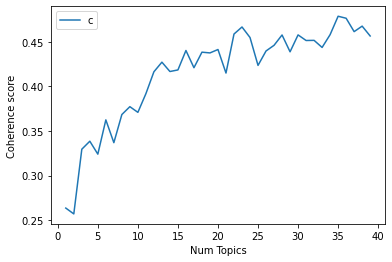

In [44]:
model_list, coherence_values = compute_coherence_values(dictionary=df_data_id2word,
                                                        corpus=df_data_corpus,
                                                        texts=df_data_lemmatized,
                                                        start=1, limit=40, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

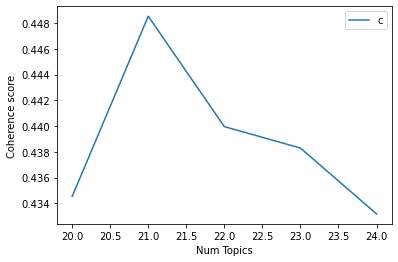

In [45]:
model_list, coherence_values = compute_coherence_values(dictionary=df_data_id2word,
                                                        corpus=df_data_corpus,
                                                        texts=df_data_lemmatized,
                                                        start=20, limit=25, step=1)
# Show graph
import matplotlib.pyplot as plt
start=20; limit=25; sstep=1;

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Visualize the topics

Now that the LDA model is built, the next step is to examine the produced 
topics and the associated keywords. There is no better tool than pyLDAvis package’s 
interactive chart and is designed to work well with jupyter notebooks.

## Overall

In [47]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(df_data_ldamodel,
                              df_data_corpus, 
                              df_data_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
19    -0.069114 -0.209676       1        1  8.350453
18    -0.028655 -0.203548       2        1  7.686594
2     -0.022698 -0.149891       3        1  7.517232
0      0.291382  0.051644       4        1  7.056627
9     -0.008111 -0.071253       5        1  6.278348
10    -0.084155  0.081441       6        1  6.065362
11     0.217819 -0.068748       7        1  5.925548
14    -0.091322  0.152412       8        1  5.845501
15    -0.049396 -0.105087       9        1  5.507030
20     0.234841  0.056039      10        1  4.530015
13     0.000121 -0.035621      11        1  4.044876
4      0.034684  0.008109      12        1  3.934209
16     0.034627  0.059863      13        1  3.911223
8     -0.083932 -0.032766      14        1  3.841720
12    -0.049917  0.081399      15        1  3.746456
17    -0.080393  0.140011      16        1  3.598034
1     -0.067152  0.042357      17        1  2.819600
5     -0.037422  0.059205      18        1  2.674263
3     -0.055589  0.044424      19        1  2.355399
6     -0.036325  0.054414      20        1  2.335461
7     -0.049292  0.045272      21        1  1.976043, topic_info=          Term       Freq      Total Category  logprob  loglift
13         bus  77.000000  77.000000  Default  30.0000  30.0000
36        taxi  52.000000  52.000000  Default  29.0000  29.0000
40      driver  87.000000  87.000000  Default  28.0000  28.0000
64        fast  48.000000  48.000000  Default  27.0000  27.0000
42         get  40.000000  40.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
350  direction   0.045081   1.142846  Topic21  -7.0389   0.6913
291       work   0.045082   1.142871  Topic21  -7.0389   0.6913
310  efficient   0.045081   1.142866  Topic21  -7.0389   0.6913
285    usually   0.045082   1.142900  Topic21  -7.0389   0.6912
351       call   0.045081   1.142880  Topic21  -7.0389   0.6912

[726 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
21        7  0.970025        able
256       5  0.603558  acceptable
70        6  0.735506  accessible
14        5  0.924767    accurate
79        5  0.756185  accurately
...     ...       ...         ...
20        1  0.946990        wait
205      17  0.952183         way
6         2  0.951706        well
45       13  0.621918       whole
228       7  0.488607       wrong

[263 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[20, 19, 3, 1, 10, 11, 12, 15, 16, 21, 14, 5, 17, 9, 13, 18, 2, 6, 4, 7, 8])